In [ ]:
# --- 1. MOUNT DRIVE & INSTALL LIBRARY ---
import os
import shutil
from google.colab import drive

# Mount Drive
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')

# Install Library (Hanya perlu sekali di awal sesi)
print("⏳ Sedang menginstall library... (Tunggu 2-3 menit)")
!pip install -q git+https://github.com/huggingface/diffusers.git
!pip install -q -U -r https://raw.githubusercontent.com/huggingface/diffusers/main/examples/text_to_image/requirements.txt
!pip install -q bitsandbytes peft accelerate transformers

# Download script training
!wget -q -nc https://raw.githubusercontent.com/huggingface/diffusers/main/examples/text_to_image/train_text_to_image_lora.py

print("✅ Setup Selesai! Sekarang kamu bisa memanggil fungsi training.")

Mounted at /content/drive
⏳ Sedang menginstall library... (Tunggu 2-3 menit)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 93.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 899.7/899.7 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 594.3/594.3 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 139.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.0/88.0 MB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 954.8/954.8 kB 61.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.1/193.1 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 73.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.6/63.6 MB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 267.5/267.5 MB 4.5 MB/s eta 0:00

In [ ]:
import os
import json
from IPython import get_ipython

def latih_lora_archive_multistyle(epochs=50, batch_size=10):
    """
    Script Khusus untuk folder 'archive' yang berisi banyak sub-folder batik.
    Otomatis mendeteksi jenis batik berdasarkan nama sub-folder.
    """

    # --- 1. SETUP PATH ---
    # Kita arahkan langsung ke folder archive
    FOLDER_UTAMA = "archive"
    DATASET_DIR = f"/content/drive/MyDrive/DL_Finalisasi/dataset/{FOLDER_UTAMA}"
    OUTPUT_DIR = f"/content/drive/MyDrive/COLAB/ModelLora_Batik_Nusantara" # Nama output keren
    MODEL_BASE = "runwayml/stable-diffusion-v1-5"

    print(f"\n{'='*50}")
    print(f"🌍 MEMULAI TRAINING BATIK NUSANTARA (MULTI-STYLE)")
    print(f"{'='*50}\n")

    if not os.path.exists(DATASET_DIR):
        print(f"❌ ERROR: Folder {DATASET_DIR} tidak ditemukan!")
        return

    # --- 2. GENERATE METADATA DINAMIS ---
    print("📂 Sedang melakukan sensus folder & membuat label otomatis...")

    metadata = []
    valid_extensions = ('.png', '.jpg', '.jpeg', '.webp')
    count = 0
    categories = set()

    # Kita loop semua sub-folder
    for root, dirs, files in os.walk(DATASET_DIR):
        # Skip folder sampah/hidden
        if ".ipynb_checkpoints" in root: continue

        # Ambil nama folder induk sebagai nama style
        # Contoh: root = ".../dataset/archive/batik-bali"
        folder_name = os.path.basename(root)

        # Jika file ada di root 'archive' (tanpa subfolder), skip atau kasih nama default
        if folder_name == "archive":
            continue

        # Bersihkan nama: "batik-bali" -> "bali"
        style_name = folder_name.replace("batik-", "").replace("batik_", "").replace("-", "_")

        # Trigger word dinamis
        caption = f"batik_style_{style_name}"

        for filename in files:
            if filename.lower().endswith(valid_extensions):
                # 1. Path Lengkap
                full_path = os.path.join(root, filename)

                # 2. Relative Path (PENTING AGAR TIDAK ERROR FILE NOT FOUND)
                # Kita hitung jarak dari DATASET_DIR ke file
                rel_path = os.path.relpath(full_path, DATASET_DIR)

                metadata.append({
                    "file_name": rel_path,
                    "text": caption
                })
                count += 1
                categories.add(style_name)

    if count == 0:
        print("❌ Tidak ada gambar ditemukan! Pastikan struktur folder benar.")
        return

    # Simpan metadata
    metadata_path = os.path.join(DATASET_DIR, "metadata.jsonl")
    with open(metadata_path, 'w') as f:
        for entry in metadata:
            json.dump(entry, f)
            f.write('\n')

    print(f"✅ Metadata selesai! Total {count} gambar.")
    print(f"🏷️  Ditemukan {len(categories)} Style Batik Berbeda:")
    print(f"   Contoh: {list(categories)[:5]} ... dst")

    # --- 3. HITUNG SAVE STRATEGY ---
    # Save per 5 epoch
    steps_per_epoch = count // batch_size
    save_steps = steps_per_epoch * 5
    if save_steps < 500: save_steps = 500

    print(f"💾 Checkpoint akan disimpan setiap {save_steps} langkah.")
    print(f"🏋️ Gas Training {epochs} Epochs...")

    # --- 4. EKSEKUSI ---
    command = (
        f"accelerate launch train_text_to_image_lora.py "
        f"--pretrained_model_name_or_path='{MODEL_BASE}' "
        f"--train_data_dir='{DATASET_DIR}' "
        f"--caption_column='text' "
        f"--resolution=512 "
        f"--random_flip "
        f"--train_batch_size={batch_size} "
        f"--gradient_accumulation_steps=1 "
        f"--num_train_epochs={epochs} "
        f"--checkpointing_steps={save_steps} "
        f"--learning_rate=1e-04 "
        f"--lr_scheduler='cosine' "
        f"--lr_warmup_steps=0 "
        f"--seed=42 "
        f"--output_dir='{OUTPUT_DIR}' "
        f"--mixed_precision='fp16'"
    )

    get_ipython().system(command)
    print(f"\n🎉 TRAINING SELESAI! Model Multi-Style tersimpan di '{OUTPUT_DIR}'")

import os
from PIL import Image

def bersihkan_dataset_corrupt(folder_dataset):
    print(f"\n{'='*50}")
    print(f"🧹 MULAI OPERASI PEMBERSIHAN FILE RUSAK")
    print(f"{'='*50}\n")

    dataset_dir = f"/content/drive/MyDrive/DL_Finalisasi/dataset/{folder_dataset}"

    if not os.path.exists(dataset_dir):
        print("❌ Folder tidak ditemukan.")
        return

    files_checked = 0
    files_deleted = 0

    for root, dirs, files in os.walk(dataset_dir):
        for filename in files:
            if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.webp')):
                file_path = os.path.join(root, filename)
                files_checked += 1

                try:
                    # Coba buka gambar
                    with Image.open(file_path) as img:
                        img.verify() # Verifikasi integritas file
                except (IOError, SyntaxError, Image.UnidentifiedImageError) as e:
                    # Jika error, berarti file rusak -> HAPUS
                    print(f"🗑️ Menghapus file rusak: {file_path}")
                    try:
                        os.remove(file_path)
                        files_deleted += 1
                    except:
                        print(f"⚠️ Gagal menghapus {filename}, silakan hapus manual.")

    print(f"\n{'='*50}")
    print(f"✅ PEMBERSIHAN SELESAI!")
    print(f"📊 Total diperiksa: {files_checked}")
    print(f"🗑️ Total dihapus  : {files_deleted}")
    print(f"{'='*50}\n")

# Jalankan pembersihan pada folder archive
bersihkan_dataset_corrupt("archive")
# Jalankan!
# Batch size 8 masih aman untuk T4 jika resolusi 512
latih_lora_archive_multistyle(epochs=80, batch_size=8)


🧹 MULAI OPERASI PEMBERSIHAN FILE RUSAK


✅ PEMBERSIHAN SELESAI!
📊 Total diperiksa: 1067
🗑️ Total dihapus  : 0


🌍 MEMULAI TRAINING BATIK NUSANTARA (MULTI-STYLE)

📂 Sedang melakukan sensus folder & membuat label otomatis...
✅ Metadata selesai! Total 1067 gambar.
🏷️  Ditemukan 20 Style Batik Berbeda:
   Contoh: ['gentongan', 'parang', 'cendrawasih', 'sidomukti', 'betawi'] ... dst
💾 Checkpoint akan disimpan setiap 665 langkah.
🏋️ Gas Training 80 Epochs...
The following values were not passed to `accelerate launch` and had defaults used instead:
	`--num_processes` was set to a value of `1`
	`--num_machines` was set to a value of `1`
	`--mixed_precision` was set to a value of `'no'`
	`--dynamo_backend` was set to a value of `'no'`
To avoid this warning pass in values for each of the problematic parameters or run `accelerate config`.
2025-12-14 05:46:57.792531: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for

In [ ]:
!pip install -q torchmetrics
import torch
from diffusers import StableDiffusionPipeline
from torchmetrics.multimodal.clip_score import CLIPScore
import matplotlib.pyplot as plt
import numpy as np

# --- 1. SETUP MODEL & METRIC ---
base_model = "runwayml/stable-diffusion-v1-5"
lora_path = "/content/drive/MyDrive/COLAB/ModelLora_Batik_Nusantara"

print("⏳ Sedang memuat model dan alat ukur...")

# A. Load Stable Diffusion
try:
    pipe = StableDiffusionPipeline.from_pretrained(
        base_model,
        torch_dtype=torch.float16,
        use_safetensors=True
    ).to("cuda")
    pipe.load_lora_weights(lora_path)
    print("✅ Model LoRA Siap!")
except Exception as e:
    print(f"❌ Gagal load model: {e}")

# B. Load CLIP Metric (Alat Ukur)
metric = CLIPScore(model_name_or_path="openai/clip-vit-base-patch16")
print("✅ CLIP Score Metric Siap!")

# --- 2. FUNGSI HITUNG SKOR ---
def get_score(image, text):
    # Konversi gambar ke format Tensor (0-255)
    img_tensor = torch.from_numpy(np.array(image)).permute(2, 0, 1)
    score = metric(img_tensor, text)
    return score.item()

# --- 3. DAFTAR STYLE YANG DITES ---
# Pastikan nama ini ada di folder dataset-mu (tanpa awalan 'batik-')
target_styles = [
    "bali",
    "kawung",
    "megamendung",
    "parang",
    "lasem"
]

# --- 4. EKSEKUSI TESTING ---
def test_multistyle_clip():
    print(f"\n{'='*60}")
    print(f"📊 PENGUJIAN MULTI-STYLE DENGAN CLIP SCORE")
    print(f"{'='*60}\n")

    cols = 3
    rows = (len(target_styles) + cols - 1) // cols
    plt.figure(figsize=(15, 6 * rows))

    for i, style in enumerate(target_styles):
        print(f"🔄 ({i+1}/{len(target_styles)}) Memproses: Batik {style.capitalize()}...")

        # Trigger Word
        trigger = f"batik_style_{style}"

        # Prompt Generasi (Lebih detail biar gambar bagus)
        gen_prompt = (
            f"close up photo of {trigger} fabric pattern, "
            f"clean {trigger} design, traditional indonesian art, "
            f"highly detailed texture, 4k, realistic"
        )

        # Prompt untuk Penilaian Skor (Lebih simpel & to-the-point)
        # Kita ingin tahu: "Apakah gambar ini benar-benar 'batik style bali'?"
        score_prompt = f"{trigger} pattern"

        # Generate Gambar
        image = pipe(
            gen_prompt,
            num_inference_steps=35,
            guidance_scale=7.5,
            cross_attention_kwargs={"scale": 0.8} # Scale aman
        ).images[0]

        # Hitung Skor
        skor = get_score(image, score_prompt)

        # Tampilkan
        plt.subplot(rows, cols, i+1)
        plt.imshow(image)

        # Judul dengan kode warna
        # Hijau (>28) = Sangat Bagus, Kuning (20-28) = Oke, Merah (<20) = Kurang
        warna_teks = "green" if skor > 28 else "orange" if skor > 20 else "red"

        plt.title(
            f"Style: {style.upper()}\n"
            f"Prompt: {score_prompt}\n"
            f"CLIP Score: {skor:.2f}",
            fontsize=12, color=warna_teks, fontweight='bold'
        )
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# Jalankan
test_multistyle_clip()

In [ ]:
!pip install -q torchmetrics
import torch
from diffusers import StableDiffusionPipeline
from torchmetrics.multimodal.clip_score import CLIPScore
import matplotlib.pyplot as plt
import numpy as np

# --- 1. SETUP MODEL & METRIC ---
base_model = "runwayml/stable-diffusion-v1-5"
lora_path = "/content/drive/MyDrive/COLAB/ModelLora_Batik_Nusantara"

print("⏳ Sedang memuat model dan alat ukur...")

# A. Load Stable Diffusion
try:
    pipe = StableDiffusionPipeline.from_pretrained(
        base_model,
        torch_dtype=torch.float16,
        use_safetensors=True
    ).to("cuda")
    pipe.load_lora_weights(lora_path)
    print("✅ Model LoRA Siap!")
except Exception as e:
    print(f"❌ Gagal load model: {e}")

# B. Load CLIP Metric (Alat Ukur)
metric = CLIPScore(model_name_or_path="openai/clip-vit-base-patch16")
print("✅ CLIP Score Metric Siap!")

# --- 2. FUNGSI HITUNG SKOR ---
def get_score(image, text):
    # Konversi gambar ke format Tensor (0-255)
    img_tensor = torch.from_numpy(np.array(image)).permute(2, 0, 1)
    score = metric(img_tensor, text)
    return score.item()

# --- 3. DAFTAR STYLE YANG DITES ---
# Pastikan nama ini ada di folder dataset-mu (tanpa awalan 'batik-')
target_styles = [
    "bali",
    "kawung",
    "megamendung",
    "parang",
    "lasem"
]

# --- 4. EKSEKUSI TESTING ---
def test_multistyle_clip():
    print(f"\n{'='*60}")
    print(f"📊 PENGUJIAN MULTI-STYLE DENGAN CLIP SCORE")
    print(f"{'='*60}\n")

    cols = 3
    rows = (len(target_styles) + cols - 1) // cols
    plt.figure(figsize=(15, 6 * rows))

    for i, style in enumerate(target_styles):
        print(f"🔄 ({i+1}/{len(target_styles)}) Memproses: Batik {style.capitalize()}...")

        # Trigger Word
        trigger = f"batik_style_{style}"

        # Prompt Generasi (Lebih detail biar gambar bagus)
        gen_prompt = (
            f"close up photo of {trigger} fabric pattern, "
            f"clean {trigger} design, traditional indonesian art, "
            f"highly detailed texture, 4k, realistic"
        )

        # Prompt untuk Penilaian Skor (Lebih simpel & to-the-point)
        # Kita ingin tahu: "Apakah gambar ini benar-benar 'batik style bali'?"
        score_prompt = f"{trigger} pattern"

        # Generate Gambar
        image = pipe(
            gen_prompt,
            num_inference_steps=35,
            guidance_scale=7.5,
            cross_attention_kwargs={"scale": 0.8} # Scale aman
        ).images[0]

        # Hitung Skor
        skor = get_score(image, score_prompt)

        # Tampilkan
        plt.subplot(rows, cols, i+1)
        plt.imshow(image)

        # Judul dengan kode warna
        # Hijau (>28) = Sangat Bagus, Kuning (20-28) = Oke, Merah (<20) = Kurang
        warna_teks = "green" if skor > 28 else "orange" if skor > 20 else "red"

        plt.title(
            f"Style: {style.upper()}\n"
            f"Prompt: {score_prompt}\n"
            f"CLIP Score: {skor:.2f}",
            fontsize=12, color=warna_teks, fontweight='bold'
        )
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# Jalankan
test_multistyle_clip()

Mounted at /content/drive
⏳ Sedang memuat model dan alat ukur...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

text_encoder/model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

safety_checker/model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

unet/diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

vae/diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`torch_dtype` is deprecated! Use `dtype` instead!
No LoRA keys associated to CLIPTextModel found with the prefix='text_encoder'. This is safe to ignore if LoRA state dict didn't originally have any CLIPTextModel related params. You can also try specifying `prefix=None` to resolve the warning. Otherwise, open an issue if you think it's unexpected: https://github.com/huggingface/diffusers/issues/new


✅ Model LoRA Siap!


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/599M [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/599M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/905 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

✅ CLIP Score Metric Siap!

📊 PENGUJIAN MULTI-STYLE DENGAN CLIP SCORE

🔄 (1/3) Memproses: Batik Kawung...


  0%|          | 0/35 [00:00<?, ?it/s]

🔄 (2/3) Memproses: Batik Megamendung...


  0%|          | 0/35 [00:00<?, ?it/s]

🔄 (3/3) Memproses: Batik Parang...


  0%|          | 0/35 [00:00<?, ?it/s]

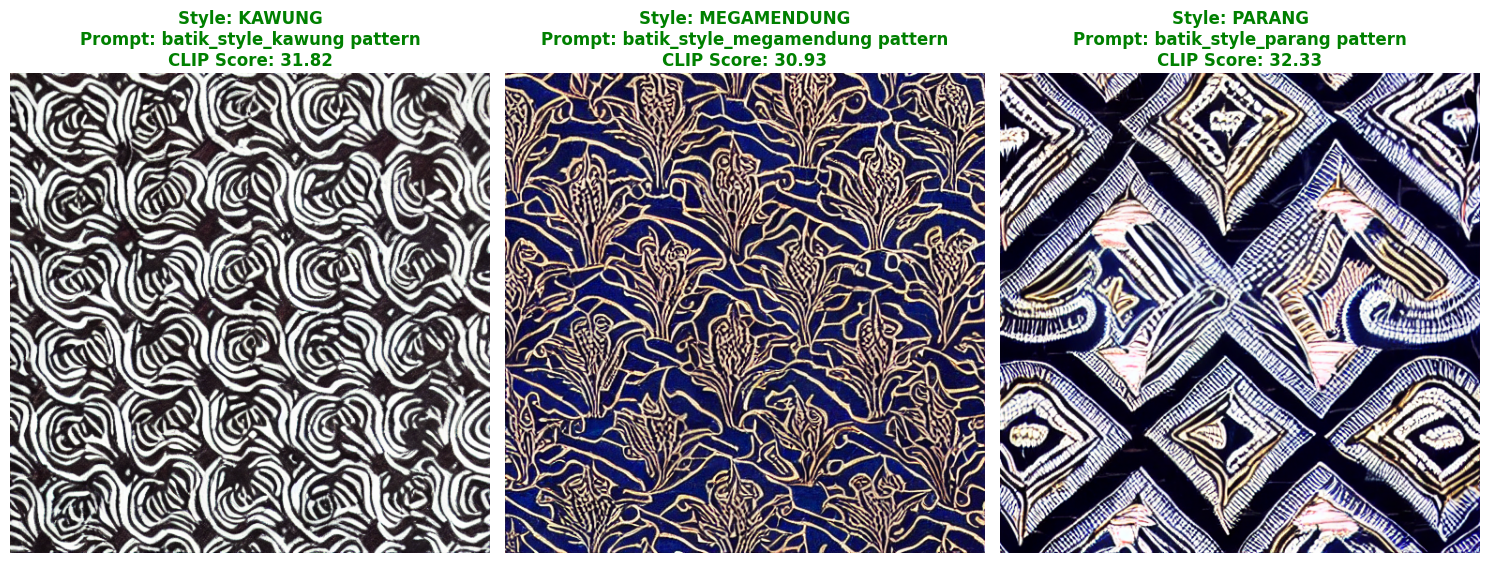

In [ ]:
!pip install -q torchmetrics
import torch
from diffusers import StableDiffusionPipeline
from torchmetrics.multimodal.clip_score import CLIPScore
import matplotlib.pyplot as plt
import numpy as np
import os
import shutil
from google.colab import drive
from google.colab import drive

# Mount Drive
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')

# --- 1. SETUP MODEL & METRIC ---
base_model = "runwayml/stable-diffusion-v1-5"
lora_path = "/content/drive/MyDrive/COLAB/ModelLora_Batik_Nusantara"

print("⏳ Sedang memuat model dan alat ukur...")

# A. Load Stable Diffusion
try:
    pipe = StableDiffusionPipeline.from_pretrained(
        base_model,
        torch_dtype=torch.float16,
        use_safetensors=True
    ).to("cuda")
    pipe.load_lora_weights(lora_path)
    print("✅ Model LoRA Siap!")
except Exception as e:
    print(f"❌ Gagal load model: {e}")

# B. Load CLIP Metric (Alat Ukur)
metric = CLIPScore(model_name_or_path="openai/clip-vit-base-patch16")
print("✅ CLIP Score Metric Siap!")

# --- 2. FUNGSI HITUNG SKOR ---
def get_score(image, text):
    # Konversi gambar ke format Tensor (0-255)
    img_tensor = torch.from_numpy(np.array(image)).permute(2, 0, 1)
    score = metric(img_tensor, text)
    return score.item()

# --- 3. DAFTAR STYLE YANG DITES ---
# Pastikan nama ini ada di folder dataset-mu (tanpa awalan 'batik-')
target_styles = [
    "kawung",
    "megamendung",
    "parang"
]

# --- 4. EKSEKUSI TESTING ---
def test_multistyle_clip():
    print(f"\n{'='*60}")
    print(f"📊 PENGUJIAN MULTI-STYLE DENGAN CLIP SCORE")
    print(f"{'='*60}\n")

    cols = 3
    rows = (len(target_styles) + cols - 1) // cols
    plt.figure(figsize=(15, 6 * rows))

    for i, style in enumerate(target_styles):
        print(f"🔄 ({i+1}/{len(target_styles)}) Memproses: Batik {style.capitalize()}...")

        # Trigger Word
        trigger = f"batik_style_{style}"

        # Prompt Generasi (Lebih detail biar gambar bagus)
        gen_prompt = (
            f"close up photo of {trigger} fabric pattern, "
            f"clean {trigger} design, traditional indonesian art, "
            f"highly detailed texture, 4k, realistic"
        )

        # Prompt untuk Penilaian Skor (Lebih simpel & to-the-point)
        # Kita ingin tahu: "Apakah gambar ini benar-benar 'batik style bali'?"
        score_prompt = f"{trigger} pattern"

        # Generate Gambar
        image = pipe(
            gen_prompt,
            num_inference_steps=35,
            guidance_scale=7.5,
            cross_attention_kwargs={"scale": 0.8} # Scale aman
        ).images[0]

        # Hitung Skor
        skor = get_score(image, score_prompt)

        # Tampilkan
        plt.subplot(rows, cols, i+1)
        plt.imshow(image)

        # Judul dengan kode warna
        # Hijau (>28) = Sangat Bagus, Kuning (20-28) = Oke, Merah (<20) = Kurang
        warna_teks = "green" if skor > 28 else "orange" if skor > 20 else "red"

        plt.title(
            f"Style: {style.upper()}\n"
            f"Prompt: {score_prompt}\n"
            f"CLIP Score: {skor:.2f}",
            fontsize=12, color=warna_teks, fontweight='bold'
        )
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# Jalankan
test_multistyle_clip()